## Market regime Detection
[LSEG source](https://developers.lseg.com/en/article-catalog/article/market-regime-detection)

### Introduction

Financial markets microstructure behaviour can vary over time, being affected by a wide range of external and internal factors. This can result in different market regimes or periods of continuous similar market conditions. Financial market participants aim to detect these market regimes and their shifts to handle potential risks and make better-informed investment decisions.

Different approaches exist allowing the classification of market regimes. Many practitioners or researchers categorise markets as "boom" or "bust" markets, while others categorise them based on volatility, such as high, low, and mid-volatility regimes. Another approach is to classify market conditions into "risk on" or "risk off" states based on the investors' appetite.

Identification of market regimes is an unsupervised process, and there is a wide range of techniques that can help to determine the current market state based on historical market data. These techniques include statistical approaches, such as vector autoregression models and hidden Markov models, as well as machine learning approaches, like clustering models e.g., k-means, agglomerative clustering, and gaussian mixture models.

[Paper on Agglomerative Clustering](https://www.sciencedirect.com/topics/computer-science/agglomerative-clustering)

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

In [2]:
ticker='XOM'
start_date="1997-01-01"
end_date=datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date)
print(data.head())
print("Getting daily close for \"{}\" from start date: {} to  end date: {}".format(ticker, start_date, end_date))

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1997-01-02  24.56250  24.62500  24.12500  24.59375  10.607158  9245200
1997-01-03  24.71875  25.03125  24.62500  24.65625  10.634119  7051200
1997-01-06  24.75000  25.03125  24.71875  25.00000  10.782378  7102000
1997-01-07  24.90625  25.06250  24.75000  25.06250  10.809325  9213200
1997-01-08  25.18750  25.21875  24.68750  24.87500  10.728457  6920400
Getting daily close for "XOM" from start date: 1997-01-01 to  end date: 2024-06-25


In [3]:
BASE_DIR = os.getcwd()
data_path = os.path.join(BASE_DIR, "data", "{}.csv".format(ticker))
data.reset_index().to_csv(data_path)
print("Data file saved: {}".format(data_path))

Data file saved: /home/thomas/projects/Proof-Of-Concept/Quant_Analysis/data/XOM.csv


In [4]:
prices = data['Close'].to_frame()
prices = prices.rename(columns={'Close': ticker})
prices.columns.name = ticker
print(prices.columns.name)
prices.head()

XOM


XOM              XOM
Date                
1997-01-02  24.59375
1997-01-03  24.65625
1997-01-06  25.00000
1997-01-07  25.06250
1997-01-08  24.87500

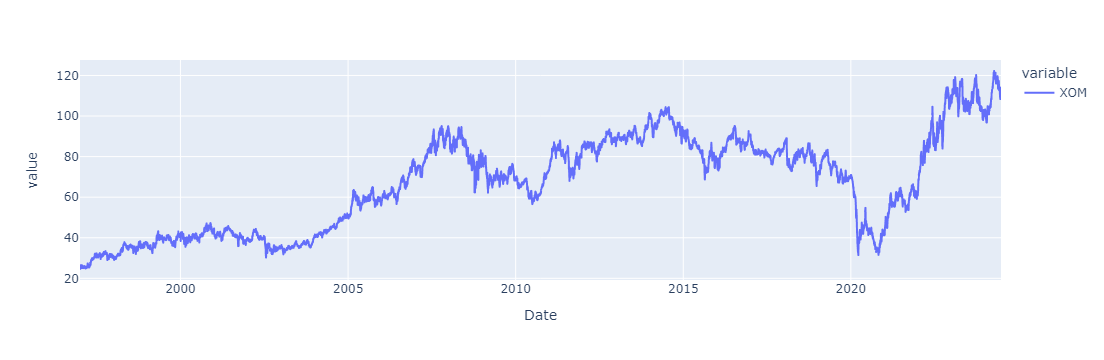

In [5]:
px.line(prices[ticker])

## Data Engineering

Before that, we prepare the data for regime detection model input. First, we derive a new feature from our data. the log return of the 7-day moving average of historical close prices.

The advantage of using log returns instead of simple returns is that log returns are both symmetric and additive over time, making them a better measure when compared across different time periods. Additionally, log returns are normalised to the current price and are not affected by the level of the asset's price. Therefore, log returns also provide a better measure when comparing the performance of different instruments.

The reason for calculating log returns on the moving average of the prices rather than the price itself is that a moving average helps to filter out random noise in the time series and smooths out short-term price changes. This allows concentrating on the long-term price movements instead.

Below, we provide a function named prepare_data_for_model_input, which applies the abovementioned approach and returns a dataframe with close price, moving average price, and its log returns. Additionally, the function will return an array of log returns that will act as input to the regime detection models discussed in the next section.

In [6]:
def prepare_data_for_model_input(prices, ma):
    '''
        Input:
        prices (df) - Dataframe of close prices
        ma (int) - legth of the moveing average
        
        Output:
        prices(df) - An enhanced prices dataframe, with moving averages and log return columns
        prices_array(nd.array) - an array of log returns
    '''
    
    instrument = prices.columns.name
    prices[f'{instrument}_ma'] = prices[instrument].rolling(ma).mean()
    prices[f'{instrument}_log_return'] = np.log(prices[f'{instrument}_ma']/prices[f'{instrument}_ma'].shift(1)).dropna()
 
    prices.dropna(inplace = True)
    prices_array = np.array([[q] for q in prices[f'{instrument}_log_return'].values])
    
    return prices, prices_array

In [7]:
prices, prices_array = prepare_data_for_model_input(prices, 7)
print(prices_array.shape)
print(prices.shape)

(6907, 1)
(6907, 3)


## Regime Detection

In this section, we briefly introduce several statistical and machine learning algorithms which we have used in this prototype to determine a market regime. Then we will use OOP to implement the regime detection process on ESc1. Finally, we will present the results of both in-sample and out-of-sample testing.

There is a wide range of methodologies that can be applied in the context of market regime identification. Techniques range from anomaly detection statistical algorithms, such as Pruned Exact Linear Time (PELT), Dynamic programming and Binary segmentation search method, Sequentially Discounting Autoregression time series modeling, hidden Markov models. Unsupervised machine learning techniques include Agglomerative, k-means clustering, and Gaussian Mixture Models. In the scope of this article, in this article we will investigate the following methodologies:

Agglomerative Clustering: A hierarchical clustering method that recursively merges pairs of clusters of sample data; using linkage distances. This process is repeated until all data points belong in one cluster or a stopping criterion is met. More about this approach can be found [here](https://www.sciencedirect.com/topics/computer-science/agglomerative-clustering).

Gaussian Mixture Model (GMM): A GMM is a probabilistic model that describes a collection of multivariate Gaussian distributions. Each Gaussian component in a GMM represents a cluster in the data, and the parameters of the Gaussian distribution (mean and covariance) are estimated from the data. The GMM algorithm uses the Expectation-Maximization (EM) algorithm to find the optimal parameters of the Gaussian distributions that best fit the data. More about this approach can be found [here](https://scikit-learn.org/stable/modules/mixture.html).

Hidden Markov Model (HMM): HMM is a sequential statistical model widely used in machine learning (i.e., speech recognition, natural language processing, bioinformatics, and finance). HMM models rely on state graphs defined by initial state probabilities, state transition probabilities, and observation emission probabilities. Transition probabilities of an HMM govern the state of the system and depending on the observations, its transition to a new state . This is the expected behaviour when using the model for analysing market regimes. The overall goal of the HMM is to estimate the underlying hidden states given the observed data. This is achieved through algorithms such as Viterbi or Baum-Welch. More about the HMM can be found [here](https://www.quantstart.com/articles/hidden-markov-models-an-introduction/).


In [8]:
class RegimeDetection:
 
    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model
    
    def get_regimes_clustering(self, params):
        clustering =  self.initialise_model(AgglomerativeClustering(), params)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm
        
    def initialise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model


## Modeling and in-sample testing

During this phase, we define a Python object named RegimeDetection encapsulating functions to determine market regimes by utilising Agglomerative clustering, GMM, and HMM models, respectively. Additionally, we define the initialise_model function, which acts as a constructor of the respective models as attributes. This allows us to instantiate the models by providing execution parameters as input rather than hard coding in the object.

Regarding regime detection functions, these accept input data (df) and params(dict) as input and return the respective model.

In [9]:
def plot_hidden_states(hidden_states, prices_df):
    
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    
    '''
    
    colors = ['blue', 'green']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
 
    for i in range(n_components):
        mask = hidden_states == i
        print('Number of observations for State ', i,":", len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df[f"{prices_df.columns.name}"][mask],
                    mode='markers',  name='Hidden State ' + str(i), marker=dict(size=4,color=colors[i])))
        
    fig.update_layout(height=400, width=900, legend=dict(
            yanchor="top", y=0.99, xanchor="left",x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()

In [10]:
regime_detection = RegimeDetection()
regime_detection

###  Agglomerative clustering

Number of observations for State  0 : 6894
Number of observations for State  1 : 13


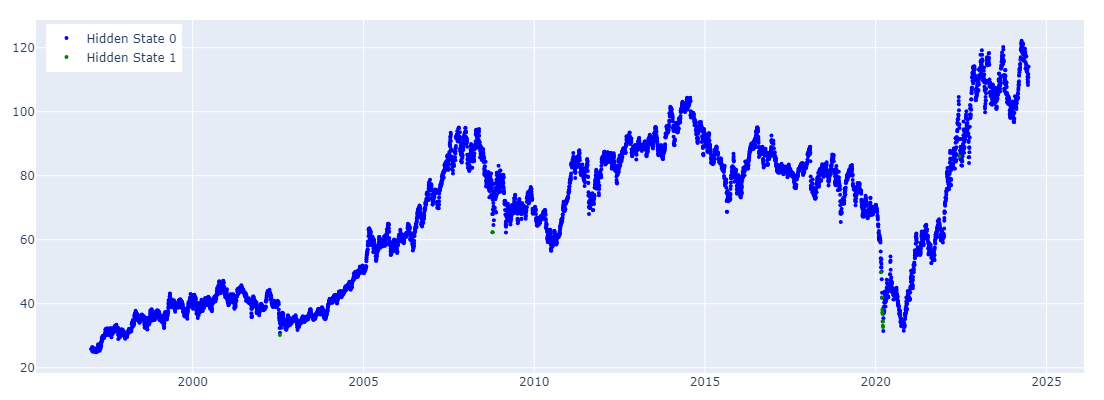

In [11]:
params = {'n_clusters': 2, 'linkage': 'complete',  'affinity': 'manhattan', 'metric': 'manhattan', 'random_state':100}
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(prices_array)
 
plot_hidden_states(np.array(clustering_states), prices[[f'{ticker}']])


### GMM model

Number of observations for State  0 : 765
Number of observations for State  1 : 6142


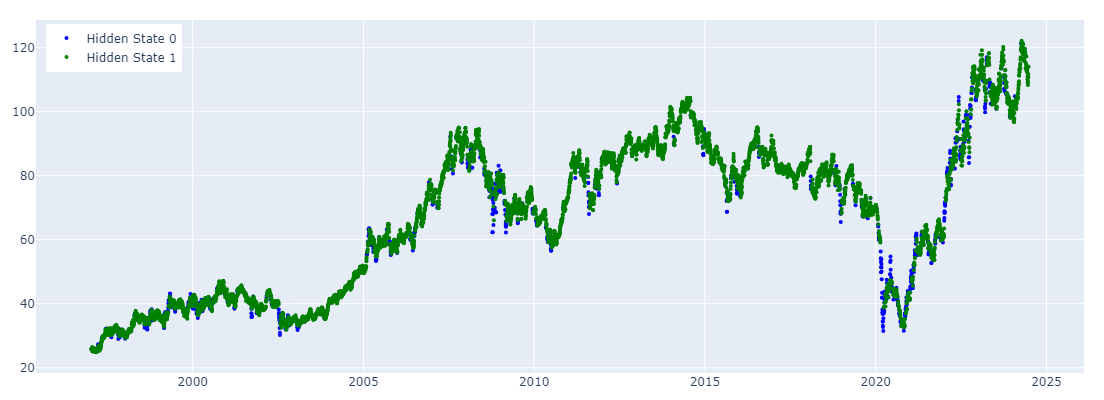

In [12]:
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
 
gmm_model = regime_detection.get_regimes_gmm(prices_array, params)
gmm_states = gmm_model.predict(prices_array)
plot_hidden_states(np.array(gmm_states), prices[[f'{ticker}']])

### HMM  Model

Number of observations for State  0 : 1031
Number of observations for State  1 : 5876


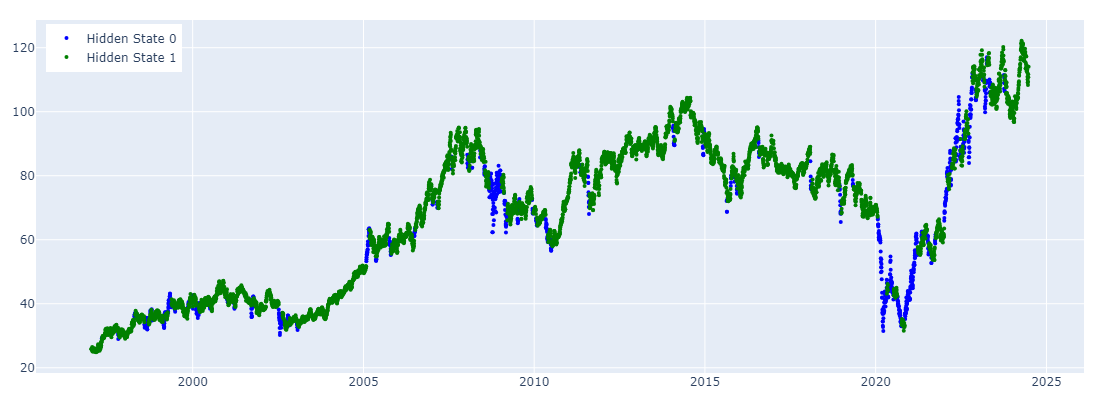

In [13]:
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}
 
hmm_model = regime_detection.get_regimes_hmm(prices_array, params)
hmm_states = hmm_model.predict(prices_array)
plot_hidden_states(np.array(hmm_states), prices[[f'{ticker}']])

### Feed-forward training and out of sample testing

Considering that in-sample testing results from agglomerative clustering were insufficient to base an investment strategy on, we implement feed-forward training and out-of-sample testing for the GMM and HMM models. To implement the feed-forward training, we define a function that: 

1. Trains the HMM or GMM model on an initial training dataset 
2. Predicts the state of the next observation 
3. Retrains the model after the specified training step - the number of observations after which we retrain.

In [14]:
def feed_forward_training(model, params, prices, split_index, retrain_step, symbol=None, base_dir=None):
    '''
    Input:
    model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
    params (dict) - dictionary of parameters for a model
    prices (df) - Dataframe of close prices
    split_index (str) - index to split initial traing dataset and out of sample testing set
    retrain_step (int) - number of observations after which we retrain the model
    
    Output:
    states_pred (numpy.ndarray) - array of predicted hidden states
    '''
    # train/test split and initial model training
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]
    rd_model = model(init_train_data, params)

    # predict the state of the next observation
    states_pred = []
    print("try to predict:({})".format(range(math.ceil(len(test_data)))))
    for i in range(math.ceil(len(test_data))):
        split_index += 1
        preds = rd_model.predict(prices[:split_index]).tolist()
        states_pred.append(preds[-1])
        
        # retrain the existing model
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)

    if (symbol is not None) and (base_dir is not None):
        pickle_path = os.path.join(base_dir, "model", f"{symbol}_{split_index}.pkl")
        pickle.dump(rd_model, open(pickle_path, "wb"))
            
    return  states_pred

First, let's investigate results for GMM by splitting the date up to 2006-01-01 (initial train set) and afterward (test set).

In [15]:
model_gmm =  regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100, 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
split_index = np.where(prices.index > '2006-01-01')[0][0]
print(split_index)

2258


### GMM Model for full time length

In [16]:
# states_pred_gmm = feed_forward_training(model_gmm, params, prices_array, split_index, 20)
# plot_hidden_states(np.array(states_pred_gmm), prices[[f'{ticker}']][split_index:])

### HMM Model for full time length

In [17]:
model_hmm =  regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type': 'full', 'random_state':100}

In [18]:
states_pred_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 20, ticker, BASE_DIR)
plot_hidden_states(np.array(states_pred_hmm), prices[[f'{ticker}']][split_index:])

try to predict:(range(0, 4649))
Number of observations for State  0 : 630
Number of observations for State  1 : 4019


The results are much better for the HMM, as we can see how it highlighted the crash periods , particularly the financial and covid pandemic period crashes. The model is showing lower stability when predicting the volatile period that started after 2022. This might be because of a change in the overall volatility regime, as during the abovementioned two crashes, there were steep and long-term dips; however, the crash after 2022 has many short-term trends and high volatility periods. This challenge can be addressed by tuning model parameters, changing the features (e.g., taking different periods moving averages) and/or changing the retraining period. None of those is implemented in the scope of this article and can be a subject to further research and analysis.

Furthermore, in this blueprint, we build a simple investment strategy that makes long, and short transactions based on the predicted outputs from the HMM.

## Simple Investment Strategy

In this section, we implement a simple investment strategy based on the predicted hidden states, which is generating: 

- A long signal when the market is expected to stay in a normal state = 1 
- A short signal when the market is in a crash or high volatility state = 0 

In this article, we have not built an end-to-end investment strategy considering transaction fees, slippage costs, margin calls, etc.; instead, we simply accumulate daily profit/loss based on the price change and our active position of the day. We then compare our strategy’s profit and loss results with a base Buy and Hold strategy.

As a first step, let us merge the daily close prices with the predicted states for that day.

In [19]:
prices_with_states = pd.DataFrame(prices[split_index:][f'{ticker}'])
prices_with_states['State'] = states_pred_hmm
prices_with_states.head()

XOM  State
Date                        
2006-01-03  58.470001      1
2006-01-04  58.570000      1
2006-01-05  58.279999      1
2006-01-06  59.430000      1
2006-01-09  59.400002      1

In [20]:
prices_with_states['P&L_daily'] = np.log(prices_with_states[ticker] / prices_with_states[ticker].shift(1)).dropna()
prices_with_states.head()

XOM  State  P&L_daily
Date                                   
2006-01-03  58.470001      1        NaN
2006-01-04  58.570000      1   0.001709
2006-01-05  58.279999      1  -0.004964
2006-01-06  59.430000      1   0.019540
2006-01-09  59.400002      1  -0.000505

Because we predict the state for a day after the market closes, and to avoid look ahead bias we will open/close a position with that day's close price but accumulate the next day's profit or loss. For that purpose, we shift the states by one day.

In [21]:
prices_with_states['State'] = prices_with_states['State'].shift(1)
prices_with_states.dropna(inplace = True)

According to the graph showing the state distribution predicted by the HMM, the _normal_ state is labeled as **State 1** and the _high Volatility_ state as **State 0**. Therefore, we will go long when the market is in State 1 and short when in State 0. We create a new column for the position, where the position is 1 when state 1, and -1, otherwise.

In [22]:
prices_with_states['Position'] = np.where(prices_with_states['State'] == 1,1,-1)
prices_with_states.head()

XOM  State  P&L_daily  Position
Date                                             
2006-01-04  58.570000    1.0   0.001709         1
2006-01-05  58.279999    1.0  -0.004964         1
2006-01-06  59.430000    1.0   0.019540         1
2006-01-09  59.400002    1.0  -0.000505         1
2006-01-10  59.860001    1.0   0.007714         1

In [23]:
prices_with_states['Daily_Outcome_hmm'] = prices_with_states['Position'] * prices_with_states['P&L_daily']
prices_with_states['Cumulative_Outcome_BaH'] = prices_with_states['P&L_daily'].cumsum()
prices_with_states['Cumulative_Outcome_hmm'] = prices_with_states['Daily_Outcome_hmm'].cumsum()
prices_with_states

XOM  State  P&L_daily  Position  Daily_Outcome_hmm  \
Date                                                                    
2006-01-04   58.570000    1.0   0.001709         1           0.001709   
2006-01-05   58.279999    1.0  -0.004964         1          -0.004964   
2006-01-06   59.430000    1.0   0.019540         1           0.019540   
2006-01-09   59.400002    1.0  -0.000505         1          -0.000505   
2006-01-10   59.860001    1.0   0.007714         1           0.007714   
...                ...    ...        ...       ...                ...   
2024-06-17  108.360001    1.0  -0.006898         1          -0.006898   
2024-06-18  109.379997    1.0   0.009369         1           0.009369   
2024-06-20  111.739998    1.0   0.021347         1           0.021347   
2024-06-21  110.760002    1.0  -0.008809         1          -0.008809   
2024-06-24  114.050003    1.0   0.029271         1           0.029271   

            Cumulative_Outcome_BaH  Cumulative_Outcome_hmm  
Date                                                        
2006-01-04                0.001709                0.001709  
2006-01-05               -0.003255               -0.003255  
2006-01-06                0.016285                0.016285  
2006-01-09                0.015780                0.015780  
2006-01-10                0.023495                0.023495  
...                            ...                     ...  
2024-06-17                0.616945               -0.112348  
2024-06-18                0.626314               -0.102979  
2024-06-20                0.647661               -0.081632  
2024-06-21                0.638852               -0.090441  
2024-06-24                0.668123               -0.061170  

[4648 rows x 7 columns]

/home/thomas/projects/Proof-Of-Concept/venv/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




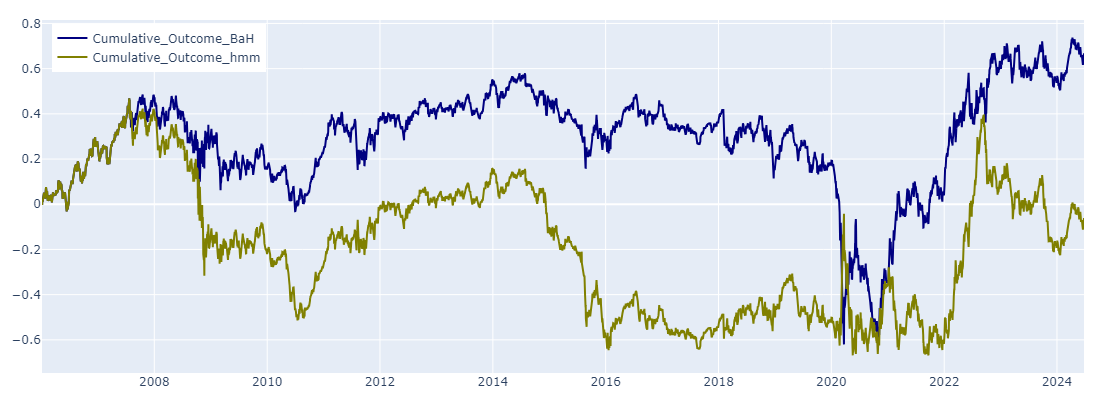

In [24]:
fig = go.Figure()
 
fig.add_trace(go.Line(x=prices_with_states.index, y=prices_with_states["Cumulative_Outcome_BaH"], 
                      name = 'Cumulative_Outcome_BaH', line_color = 'navy'))
 
fig.add_trace(go.Line(x= prices_with_states.index, y=prices_with_states['Cumulative_Outcome_hmm'], 
                      name = 'Cumulative_Outcome_hmm', line_color = 'olive'))
 
fig.update_layout(height=400, width=900, legend=dict(
    yanchor="top", y=0.99, xanchor="left",x=0.01), 
    margin=dict(l=20, r=20, t=20, b=20))
 
fig.show()